In [15]:
from os.path import isfile, join
from os import listdir
from tqdm.auto import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
from modules.models import ResnetGenerator
from modules.dataset import make_dataloader

from config import TrainerConfig, ModelConfig

In [16]:
train_config = TrainerConfig()
model_config = ModelConfig()
device_num = 4
path_data = 'AAPM_data'
device = torch.device(f"cuda:{device_num}" if torch.cuda.is_available() else "cpu")
_, test_dataloader = make_dataloader(path_data, train_config.batch_size)

In [17]:
# Designate the model path
train_config.path_checkpoint = 'CT_denoising_best'
model_config.model_name = 'cyclegan_best_supervised'
path_result = join(train_config.path_checkpoint, model_config.model_name)

In [18]:
c = model_config

G_Q2F_sup = ResnetGenerator(
    *c.G_Q2F_sup.args, **c.G_Q2F_sup.kwargs
).to(device)        

In [20]:
from tqdm.auto import tqdm

# Load the last checkpoint
checkpoint = torch.load(join(train_config.path_checkpoint, model_config.model_name + '.pth'))
G_Q2F_sup.load_state_dict(checkpoint['G_Q2F_sup_state_dict'])
G_Q2F_sup.eval()

# Test and save
with torch.no_grad():
  for _, x_Q, file_name in tqdm(test_dataloader):
    x_Q = x_Q.to(device)
    x_QF = G_Q2F_sup(x_Q)[0].detach().cpu().numpy()
    x_QF = x_QF * 4000

    np.save(join(path_result, file_name[0]), x_QF)

  0%|          | 0/421 [00:00<?, ?it/s]

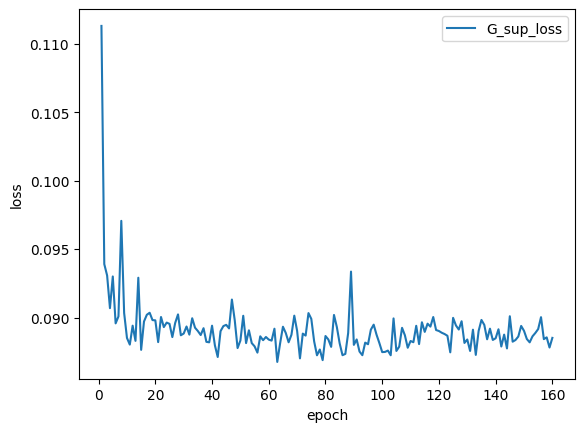

In [21]:
# Plot loss graph (supervised learning loss)
x_axis = np.arange(1, train_config.num_epoch + 1)
plt.figure(1)
loss_arr = torch.load(join(path_result, 'G_sup_loss' + '.npy'))
loss_arr = [tensor.cpu().numpy() for tensor in loss_arr]
plt.plot(x_axis, loss_arr, label='G_sup_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig(join(path_result, 'loss_curve_3.png'))
plt.show()

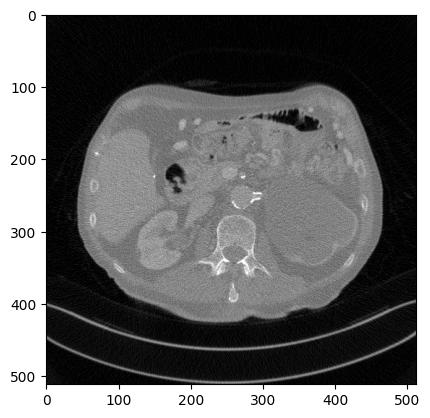

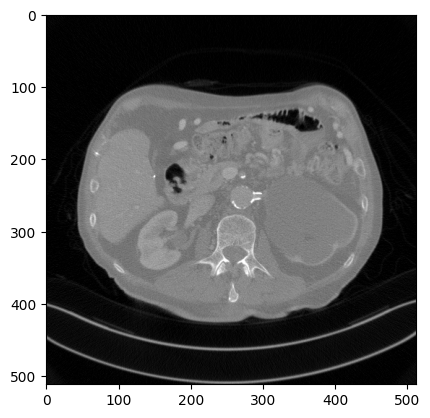

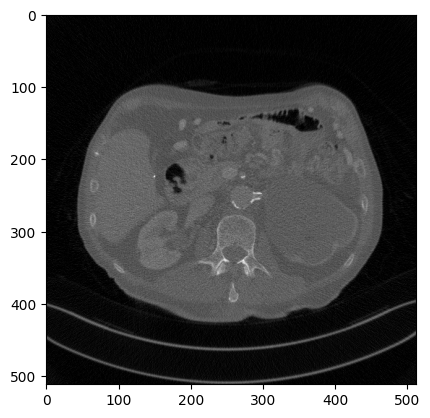

In [22]:
# Example of result
path_quarter = join(path_data, 'test/quarter_dose/100.npy')
path_full = join(path_data, 'test/full_dose/100.npy')
path_output = join(path_result, '100.npy')

quarter = np.load(path_quarter)
full = np.load(path_full)
output = np.load(path_output)

quarter = (quarter - 0.0192) / 0.0192 * 1000
full = (full - 0.0192) / 0.0192 * 1000

quarter = np.clip(quarter, -1000, 1000)
full = np.clip(full, -1000, 1000)
output = np.clip(output, -1000, 1000)

output = np.transpose(output, (1, 2, 0))

plt.imshow(quarter, cmap='gray')
plt.show()
plt.imshow(full, cmap='gray')
plt.show()
plt.imshow(output, cmap='gray')
plt.show()

In [23]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Functions for caculating PSNR, SSIM
def psnr(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = peak_signal_noise_ratio(ref, A)
  return out

def ssim(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = structural_similarity(ref, A, data_range=2)
  return out

  0%|          | 0/421 [00:00<?, ?it/s]

Mean PSNR between network output (supervised learning) and ground truth: 13.278239949966935
Mean SSIM between network output (supervised learning) and ground truth: 0.37455551881057497


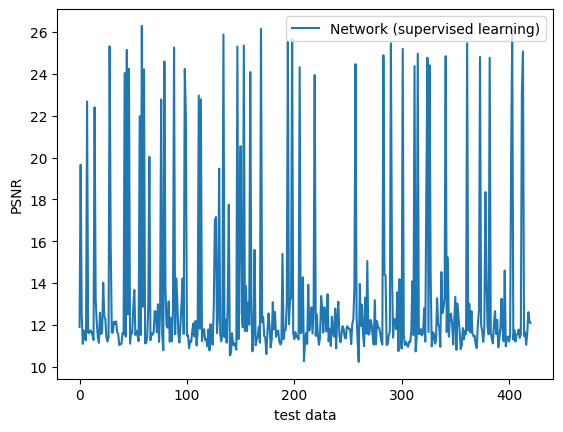

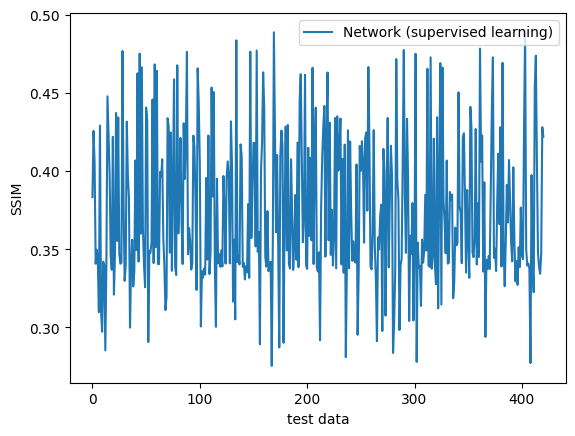

In [24]:
# Average value of all test data (PSNR, SSIM)
psnr_list_input = list()
psnr_list_network = list()
psnr_list_network_sup = list()
ssim_list_input = list()
ssim_list_network = list()
ssim_list_network_sup = list()

for file_name in tqdm(listdir(join(path_data, 'test/full_dose'))):
    path_quarter = join(path_data, 'test/quarter_dose', file_name)
    path_full = join(path_data, 'test/full_dose', file_name)
    path_output = join(path_result, file_name)
    path_output_sup = join(path_result, file_name)
    
    quarter = np.load(path_quarter)
    full = np.load(path_full)
    output_sup = np.load(path_output_sup)
    output_sup = np.transpose(output_sup, (1, 2, 0)).squeeze(2)
    
    quarter = (quarter - 0.0192) / 0.0192 * 1000
    full = (full - 0.0192) / 0.0192 * 1000
    
    psnr_list_network_sup.append(psnr(output_sup, full))
    ssim_list_network_sup.append(ssim(output_sup, full))
    
print('Mean PSNR between network output (supervised learning) and ground truth:', np.mean(psnr_list_network_sup))
print('Mean SSIM between network output (supervised learning) and ground truth:', np.mean(ssim_list_network_sup))

# figure
plt.figure(1)
plt.plot(psnr_list_network_sup, label='Network (supervised learning)')
plt.xlabel('test data')
plt.ylabel('PSNR')
plt.legend(loc='upper right')
plt.savefig(join(path_result, 'psnr_curve.png'))
plt.show()

plt.figure(2)
plt.plot(ssim_list_network_sup, label='Network (supervised learning)')
plt.xlabel('test data')
plt.ylabel('SSIM')
plt.legend(loc='upper right')
plt.savefig(join(path_result, 'ssim_curve.png'))
plt.show()

# Save the results
np.save(join(path_result, 'psnr_list_network_sup.npy'), np.array(psnr_list_network_sup))
np.save(join(path_result, 'ssim_list_network_sup.npy'), np.array(ssim_list_network_sup))